<h1 align = "center">Code</h1> 

## 加载可能用到的包

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scipy.stats as stats
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings(action='ignore')

## 读取数据集

In [7]:
diabetes_df = pd.read_csv("/Users/zhangyaoyuan/Desktop/课程/编程基础/hw_fin/diabetes.csv")
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [8]:
diabetes_df.shape

(768, 9)

In [9]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [10]:
#捕获异常；
def ISNULL(df):
    flag = df.isnull().sum()
    if flag.sum():
        print('存在异常值！')
        raise ValueError
    else:
        print('不存在异常值')

In [12]:
ISNULL(diabetes_df)

不存在异常值


In [13]:
diabetes_df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

可见数据集中没有缺失值，因此不用对缺失值进行预处理。

In [14]:
diabetes_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


可见在数据集中，许多特征的最小值min()为0，猜测这些0值很有可能为缺失值。

## 数据预处理

### 数据集是否平衡

Text(0.5, 1.0, 'Distribution of Outcome')

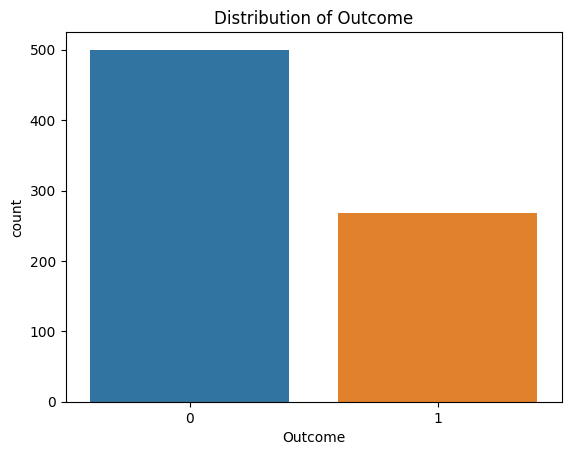

In [15]:
sns.countplot(x='Outcome',data=diabetes_df).set_title('Distribution of Outcome')

In [16]:
diabetes_df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

本样本共768个样本,其中未患病个数为500个,比例为65.1%;患病个数为268个,比例为34.9%。可以看出此数据集是不平衡的，若不对此进行平衡化处理，预测结果会偏向于未患病（取值为0）的结果，因此后续需要对数据集进行平衡化处理。

### 对各个特征中的0值进行处理

In [17]:
#用缺失值nan代替0值；
d_copy = diabetes_df.copy()
d_copy = d_copy.drop(columns=['Outcome'],axis=1)
d_copy = d_copy.replace(0,np.nan)

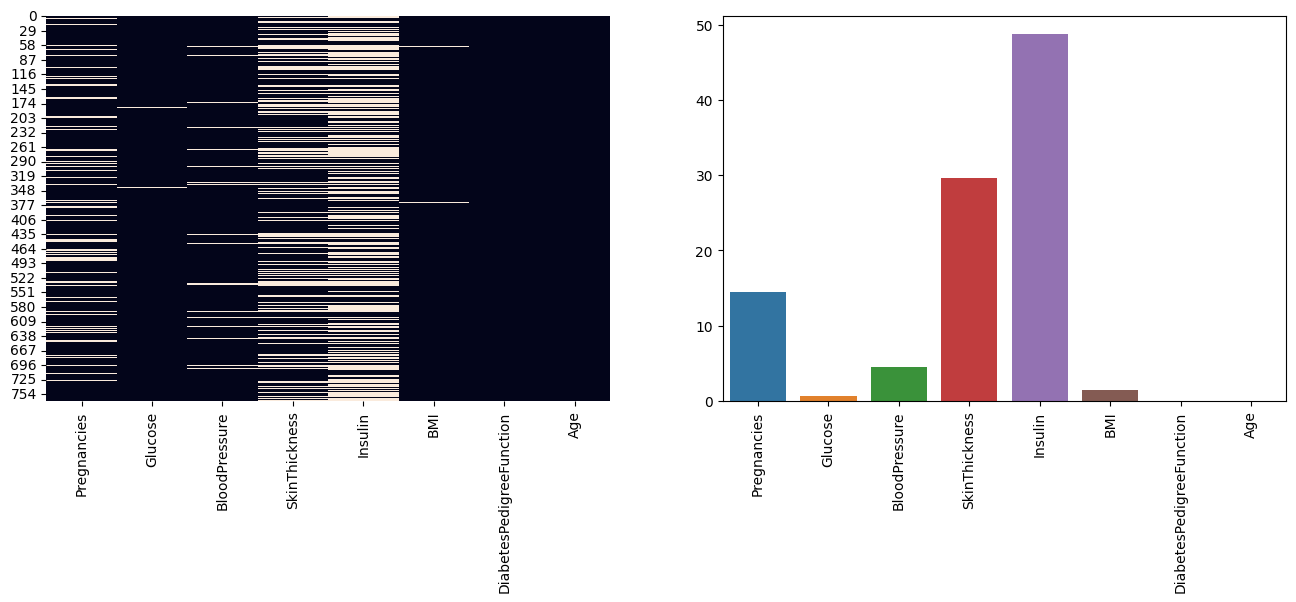

In [18]:
#可视化缺失值；
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.heatmap(d_copy.isnull(), cbar=False, ax=ax1)
percent_missing = d_copy.isnull().mean() * 100
sns.barplot(x=percent_missing.index, y=percent_missing ,ax=ax2)
plt.xticks(rotation=90)
plt.show()

可见Insulin和SkinThickness的缺失值比例较高，分别达到了50%和30%，这提示我们在后续分析中，我们需要对缺失值进行插补。

### 划分数据集

In [19]:
X = diabetes_df.iloc[:,:-1]
y = diabetes_df.iloc[:,-1]

In [20]:
#按照3:1的比例划分训练集和测试集；
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_train=pd.concat([X_train, y_train], axis=1)
X_test=pd.concat([X_test, y_test], axis=1)
X_train.to_csv('train_data.csv', index=False)
X_test.to_csv('test_data.csv', index=False)
print(X_train.shape)
print(y_train.shape)

(576, 9)
(576,)


### 各个特征的分布情况

<Figure size 3000x1500 with 0 Axes>

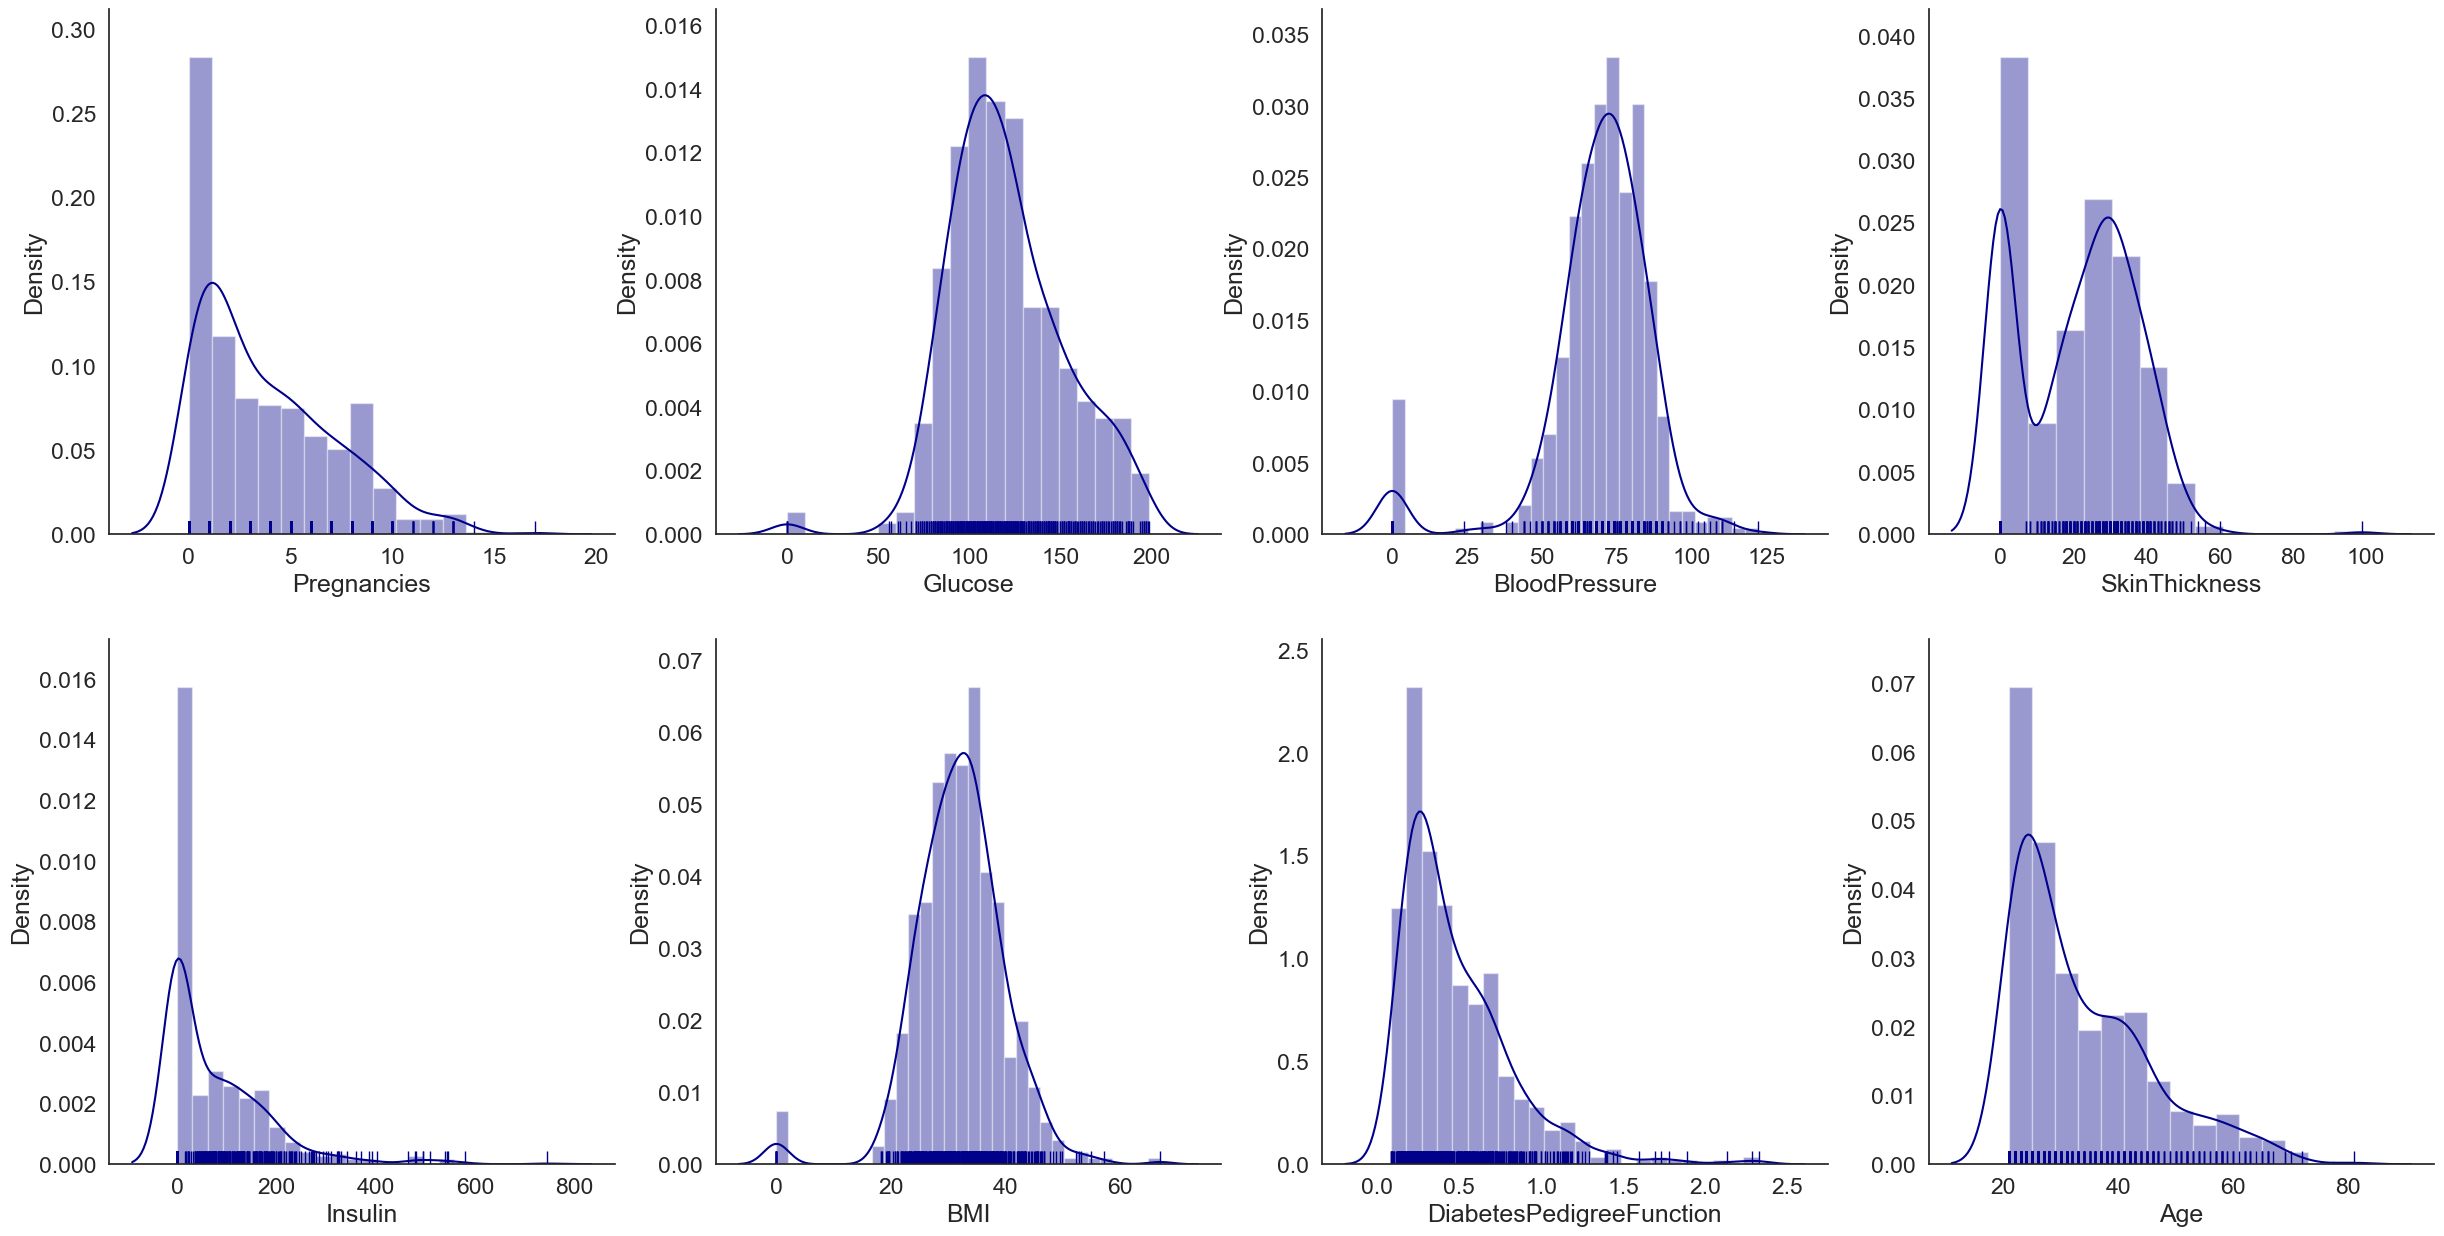

In [22]:
num_cols=diabetes_df.columns
rcParams['figure.figsize'] =30,15
sns.set(font_scale = 1.5)
sns.set_style("white")
plt.subplots_adjust(hspace=1)
fig, axes = plt.subplots(2, 4)
for i in range(4):
    sns.distplot(X_train[num_cols[i]],ax = axes[0,i],rug=True,color='darkblue')
    sns.despine()
for i in range(4,8):
    sns.distplot(X_train[num_cols[i]],ax = axes[1,i-4],rug=True,color='darkblue')
    sns.despine()

Pregnancies,Insulin,DiabetesPedigreeFunction,SkinThickness和Age的分布是右偏的；Glucose,BloodPressure和BMI近似正态分布

### 自定义类用于数据预处理

In [23]:
class Preprocess:
    def __init__(self,cond,m):
        self.cond = cond
        self.m = m
    def out_remove(self,col_name,df):
        quartile1 = df[col_name].quantile(0.25)
        quartile3 = df[col_name].quantile(0.75)
        iqr = quartile3 - quartile1
        upper = quartile3 + self.m * iqr
        lower = quartile1 - self.m * iqr
        if(self.cond=='both'):
            new_df = df[(df[col_name] < upper) & (df[col_name] > lower)]
        elif(self.cond=='lower'):
            new_df = df[(df[col_name] > lower)]
        else:
            new_df = df[(df[col_name] < upper)]
        return new_df

In [24]:
ppc1 = Preprocess('both',1.5)#两边去除
ppc2 = Preprocess('lower',1.5)#去除左尾

### Pregnancies

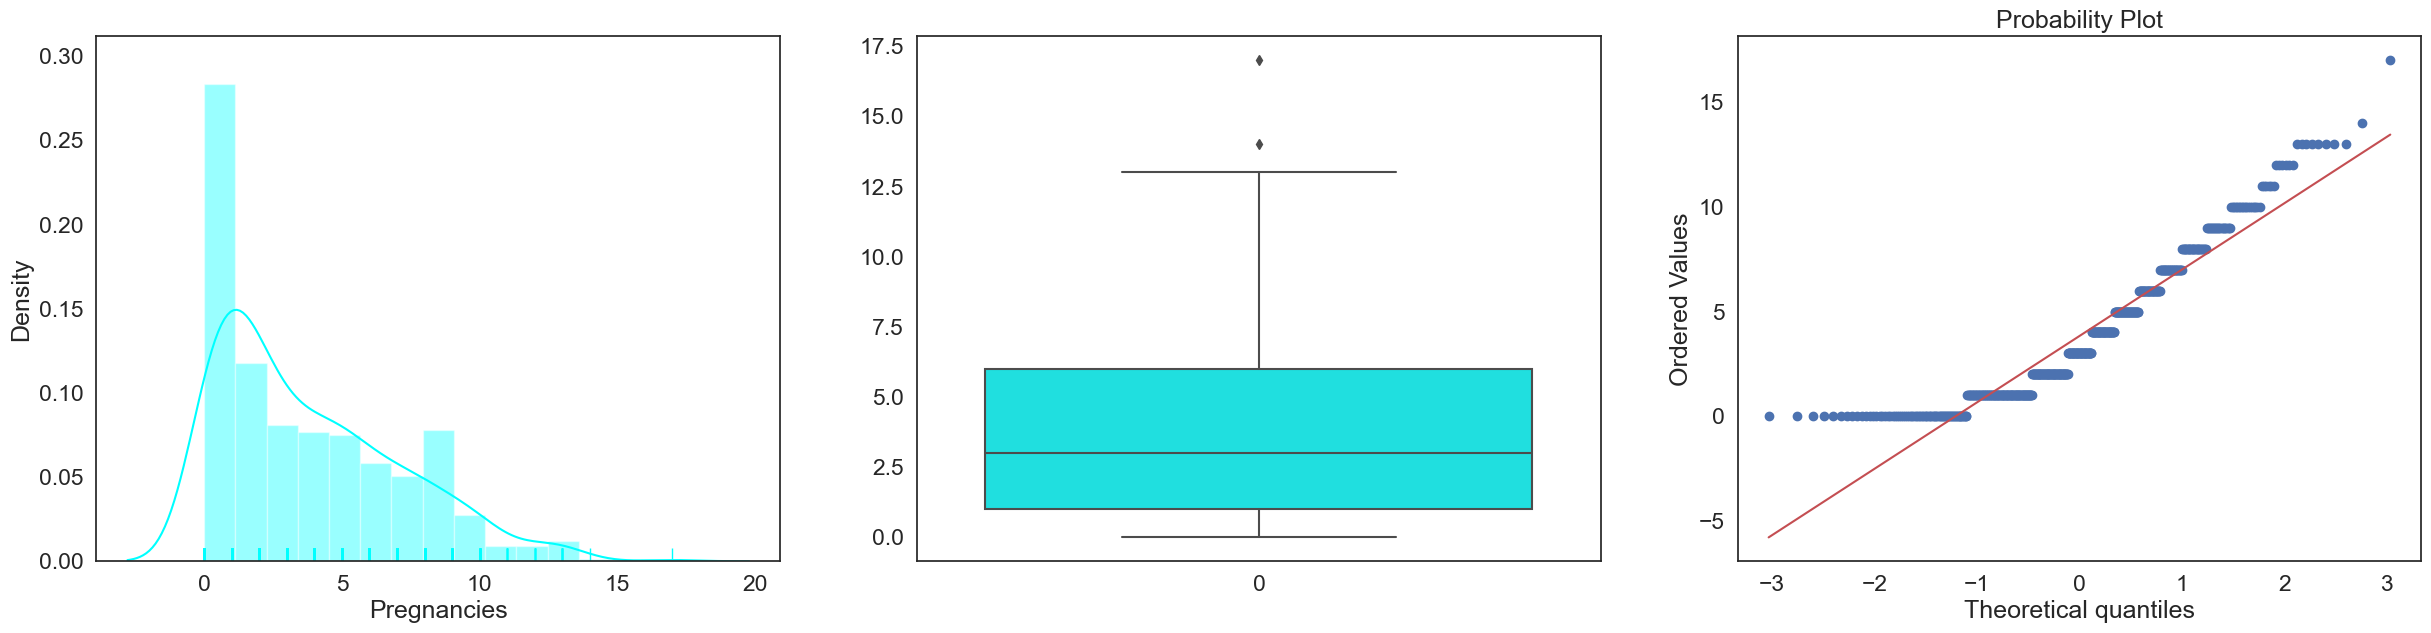

In [25]:
#概率密度曲线、箱线图与P-P图；
fig, axes = plt.subplots(1,3)
for i in range(1):
    sns.distplot(X_train[num_cols[0]],ax = plt.subplot(2,3,1),rug=True,color='Aqua')
    sns.boxplot(X_train[num_cols[0]],ax = plt.subplot(2,3,2),color='Aqua')  
    stats.probplot(X_train[num_cols[0]],plot = plt.subplot(2,3,3))  

这里0值不是缺失值而是正常现象，但也有少部分异常值，因此需要对异常值进行去除

In [26]:
#识别并处理异常值；
X_train = ppc1.out_remove('Pregnancies',X_train)
X_test = ppc1.out_remove('Pregnancies',X_test)

### Glucose

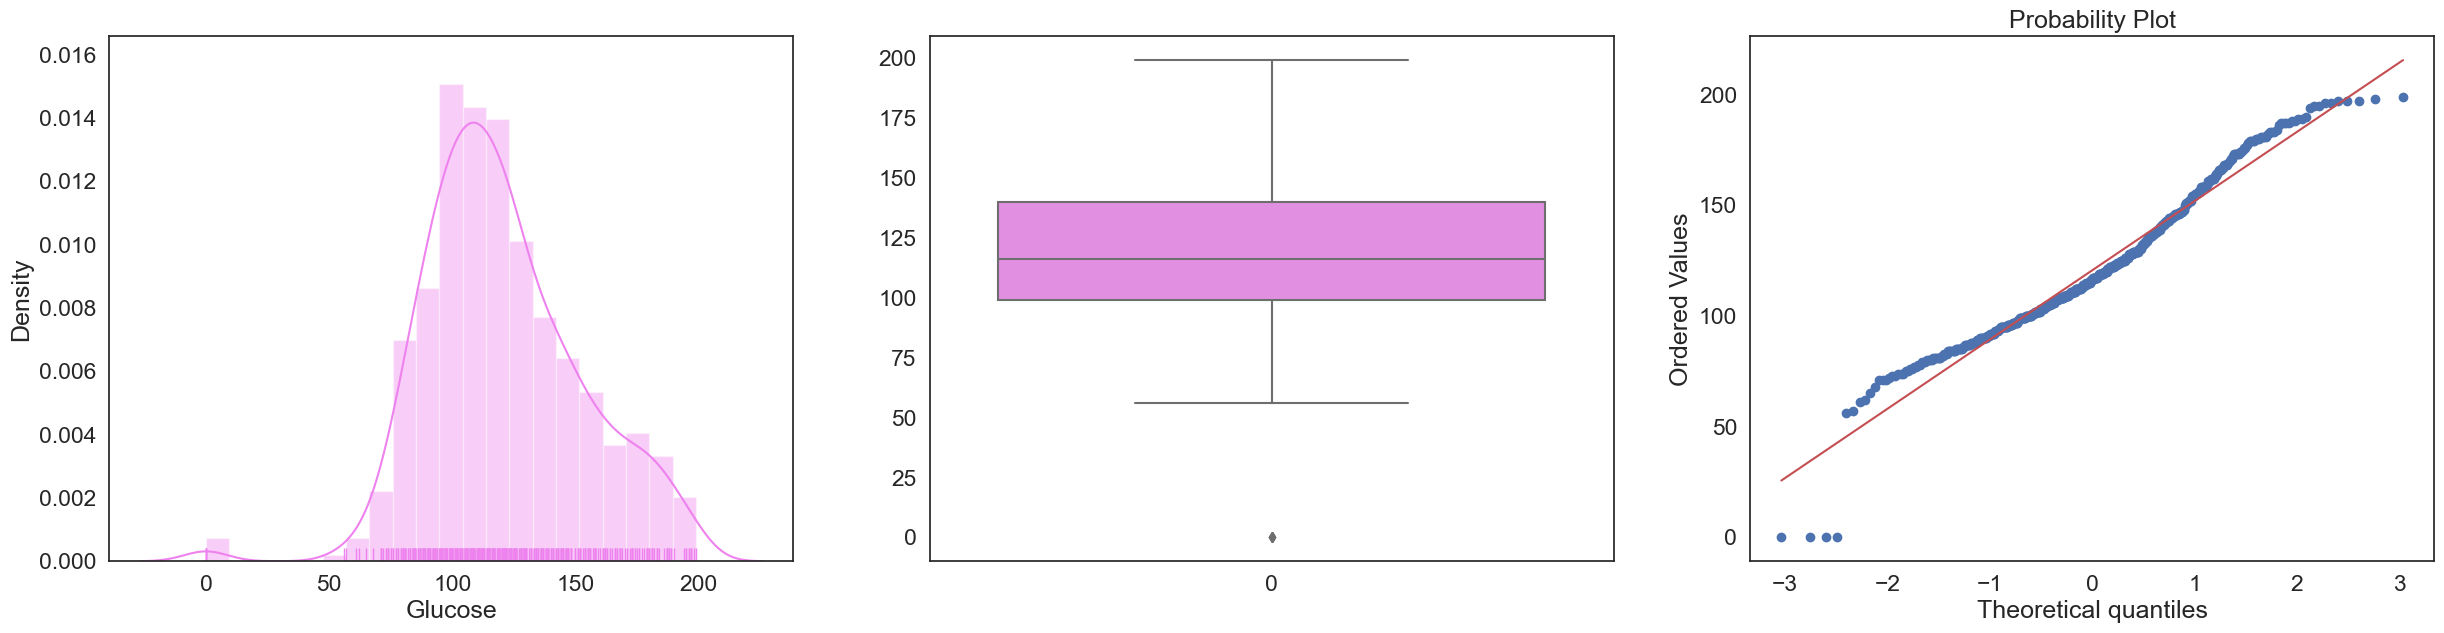

In [27]:
#概率密度曲线、箱线图与P-P图；
fig, axes = plt.subplots(1,3)
for i in range(1):
    sns.distplot(X_train[num_cols[1]],ax = plt.subplot(2,3,1),rug=True,color='Violet')
    sns.boxplot(X_train[num_cols[1]],ax = plt.subplot(2,3,2),color='Violet')  
    stats.probplot(X_train[num_cols[1]],plot = plt.subplot(2,3,3)) 

这里0值为缺失值，且没有其他异常值；因此只需要对0值（缺失值）进行插补，这里采用均值插补

In [28]:
X_train['Glucose'] = X_train['Glucose'].replace(0,X_train['Glucose'].mean())
X_test['Glucose'] = X_test['Glucose'].replace(0,X_test['Glucose'].mean())

In [29]:
X_train = ppc1.out_remove('Glucose',X_train)
X_test = ppc1.out_remove('Glucose',X_test)

### BloodPressure

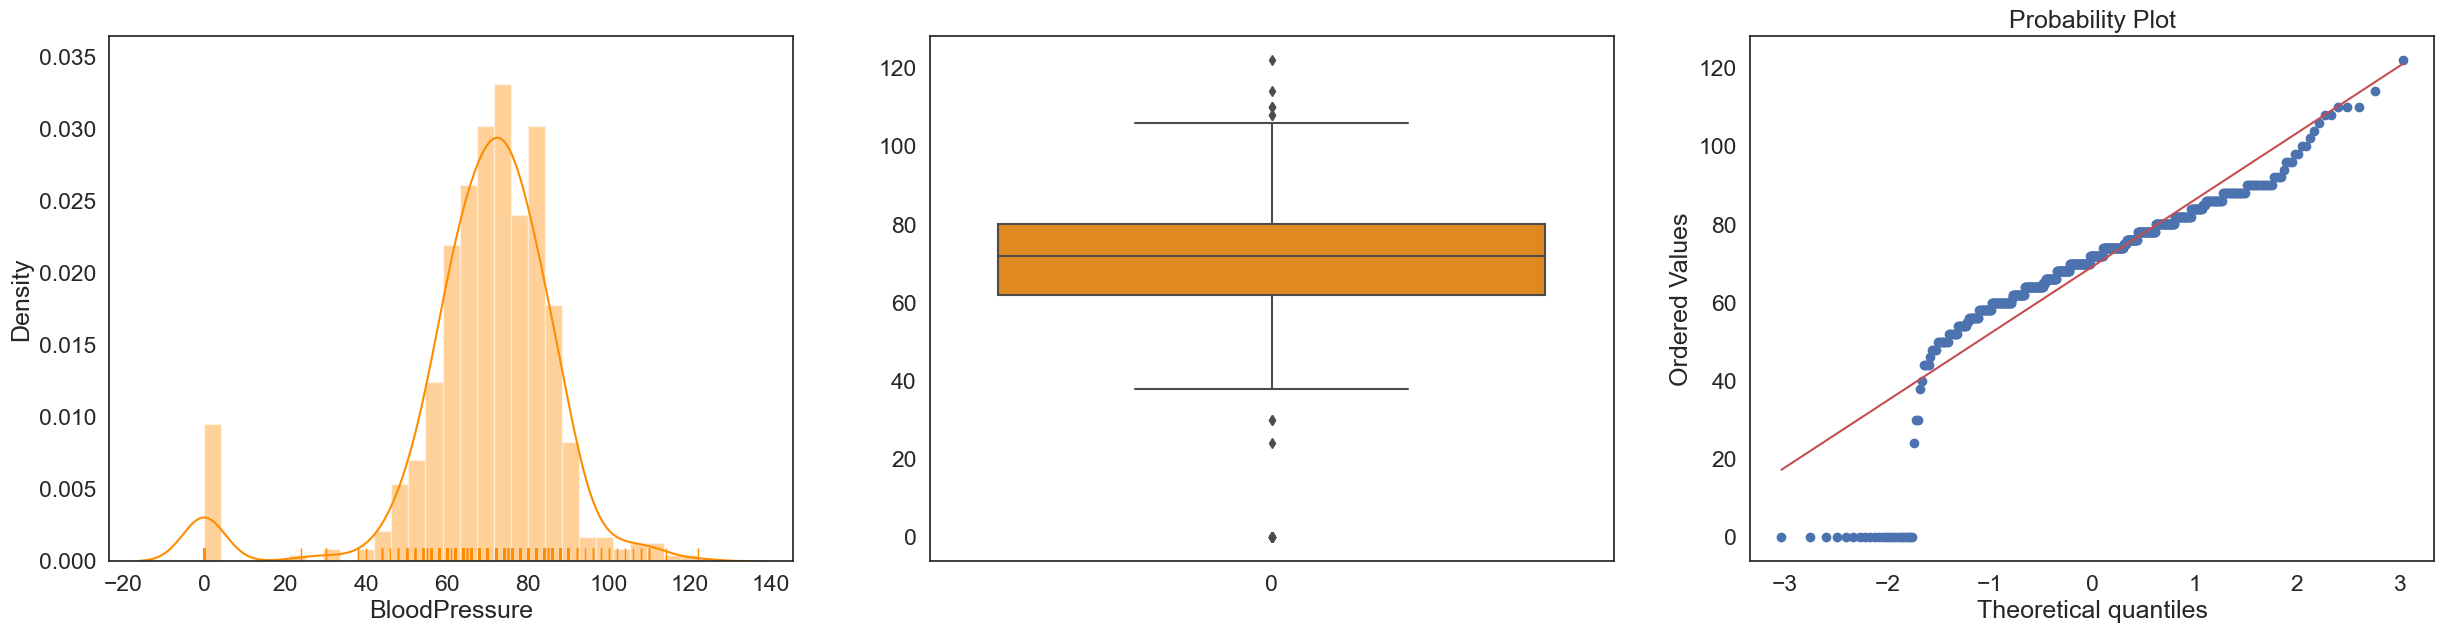

In [30]:
#概率密度曲线、箱线图与P-P图；
fig, axes = plt.subplots(1,3)
for i in range(1):
    sns.distplot(X_train[num_cols[2]],ax = plt.subplot(2,3,1),rug=True,color='DarkOrange')
    sns.boxplot(X_train[num_cols[2]],ax = plt.subplot(2,3,2),color='DarkOrange')  
    stats.probplot(X_train[num_cols[2]],plot = plt.subplot(2,3,3)) 

由以上几幅图可见，在头部和尾部都有少量异常值。但在最高处血压是122并非异常值；而在25点附近的值显然不符合实际情况。
所以我们决定用中位数来插补0值（缺失值），并去除异常值。

In [31]:
X_train['BloodPressure'] = X_train['BloodPressure'].replace(0,X_train['BloodPressure'].median())
X_test['BloodPressure'] = X_test['BloodPressure'].replace(0,X_test['BloodPressure'].median())

In [32]:
X_train = ppc2.out_remove('BloodPressure',X_train)
X_test = ppc2.out_remove('BloodPressure',X_test)

### SkinThickness

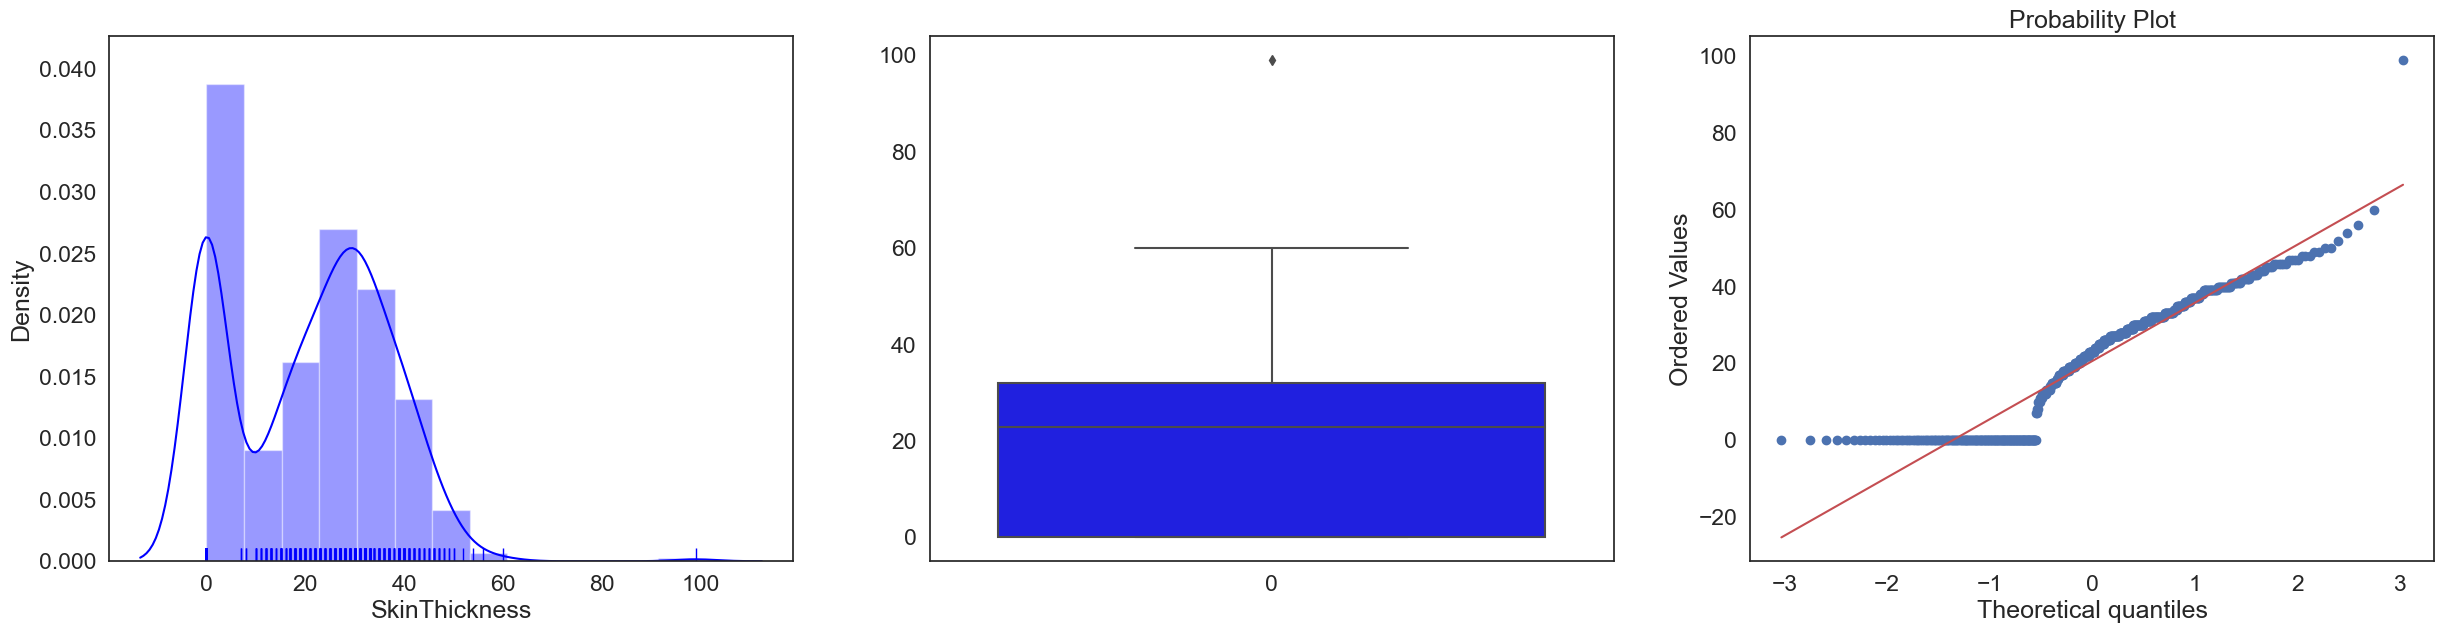

In [33]:
#概率密度曲线、箱线图与P-P图；
fig, axes = plt.subplots(1,3)
for i in range(1):
    sns.distplot(X_train[num_cols[3]],ax = plt.subplot(2,3,1),rug=True,color='blue')
    sns.boxplot(X_train[num_cols[3]],ax = plt.subplot(2,3,2),color='blue')  
    stats.probplot(X_train[num_cols[3]],plot = plt.subplot(2,3,3)) 

In [34]:
X_train['SkinThickness'] = X_train['SkinThickness'].replace(0,X_train['SkinThickness'].mean())
X_test['SkinThickness'] = X_test['SkinThickness'].replace(0,X_test['SkinThickness'].mean())

In [35]:
X_train = ppc1.out_remove('SkinThickness',X_train)
X_test = ppc1.out_remove('SkinThickness',X_test)

### Insulin

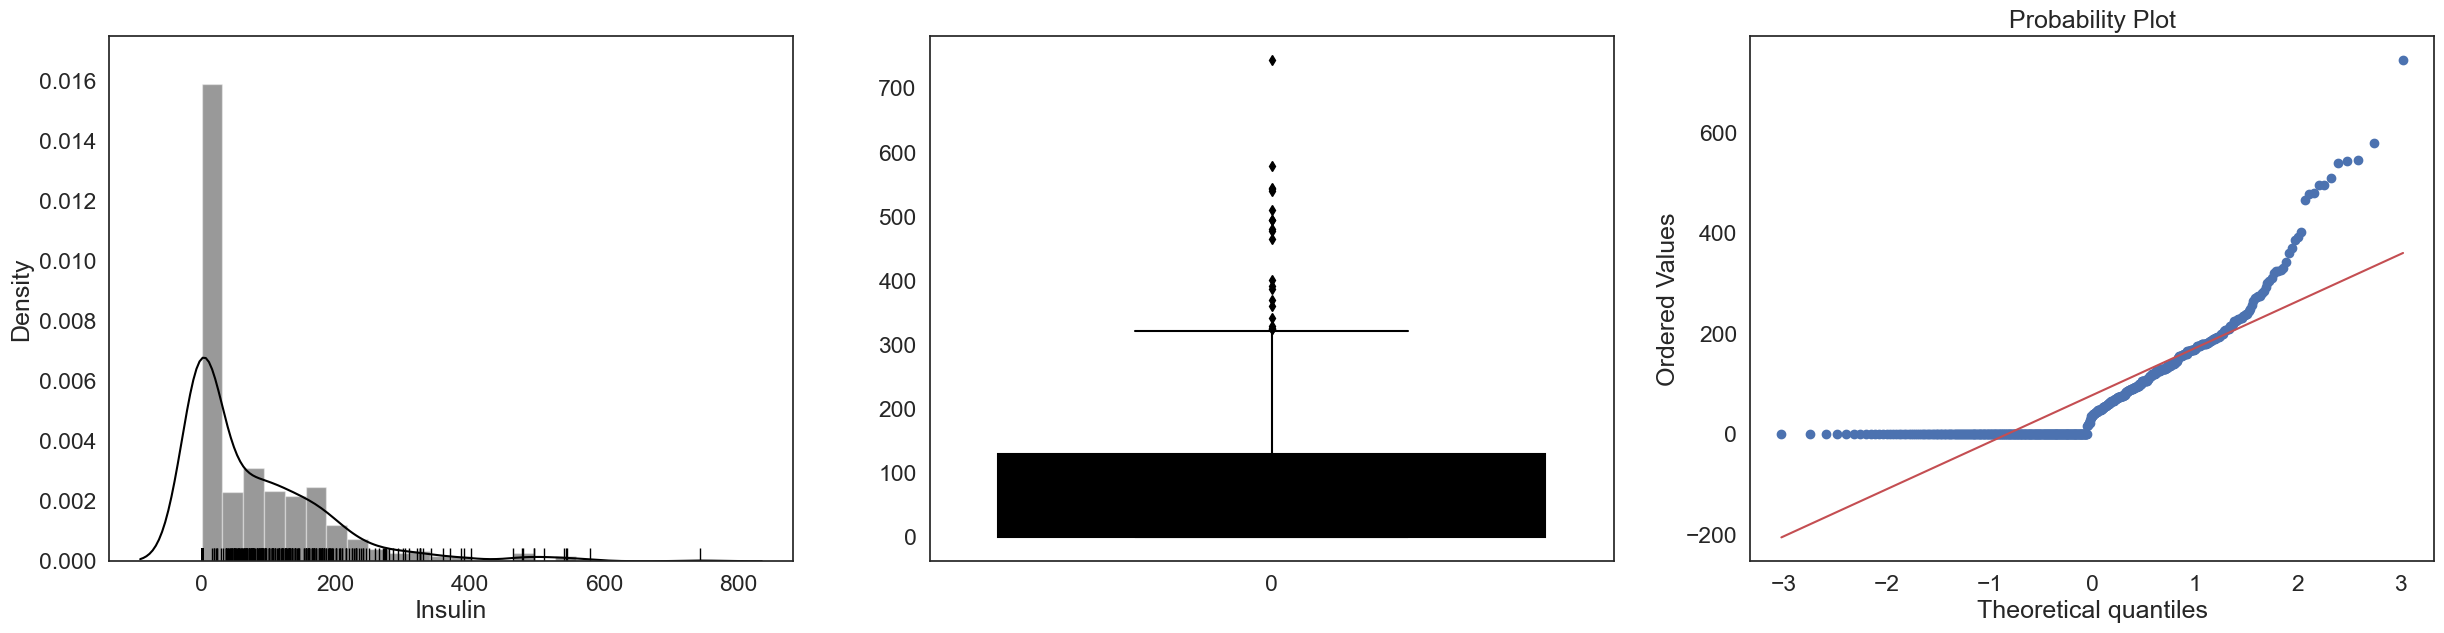

In [36]:
#概率密度曲线、箱线图与P-P图；
fig, axes = plt.subplots(1,3)
for i in range(1):
    sns.distplot(X_train[num_cols[4]],ax = plt.subplot(2,3,1)  ,rug=True,color='black')
    sns.boxplot(X_train[num_cols[4]],ax = plt.subplot(2,3,2)  ,color='black')  
    stats.probplot(X_train[num_cols[4]],plot = plt.subplot(2,3,3)) 

In [37]:
X_train['Insulin'] = X_train['Insulin'].replace(0,X_train['Insulin'].median())
X_test['Insulin'] = X_test['Insulin'].replace(0,X_test['Insulin'].median())

In [38]:
X_train = ppc1.out_remove('Insulin',X_train)
X_test = ppc1.out_remove('Insulin',X_test)

### BMI

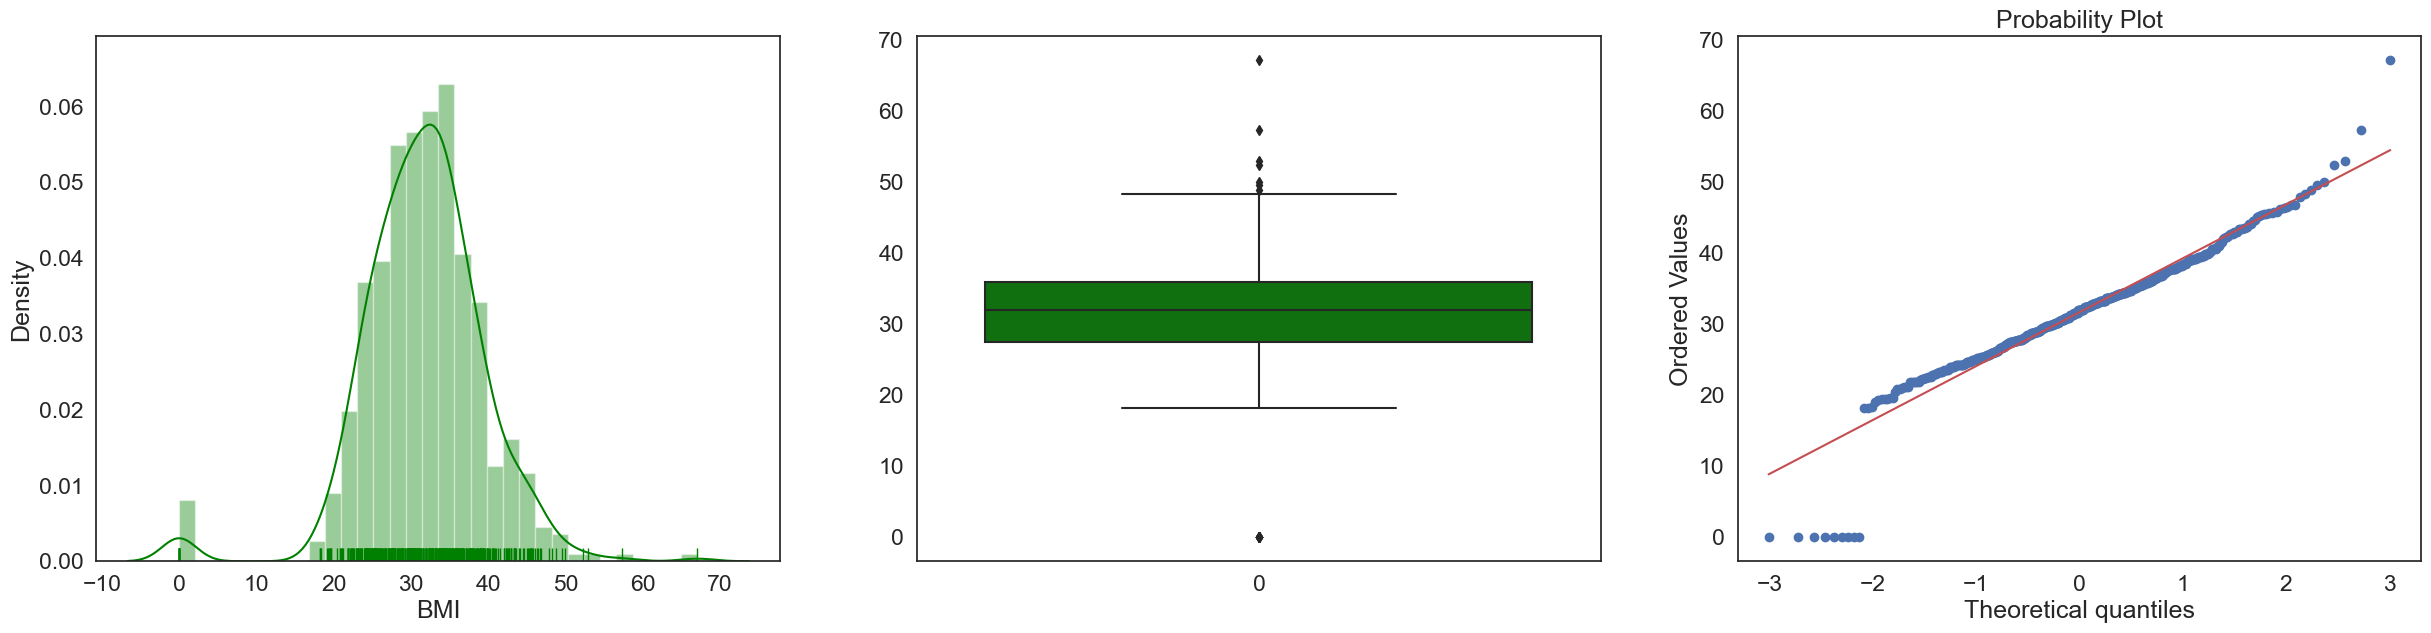

In [39]:
#概率密度曲线、箱线图与P-P图；
fig, axes = plt.subplots(1,3)
for i in range(1):
    sns.distplot(X_train[num_cols[5]],ax = plt.subplot(2,3,1)  ,rug=True,color='green')
    sns.boxplot(X_train[num_cols[5]],ax = plt.subplot(2,3,2)  ,color='green')  
    stats.probplot(X_train[num_cols[5]],plot = plt.subplot(2,3,3)) 

In [40]:
X_train['BMI'] = X_train['BMI'].replace(0,X_train['BMI'].mean())
X_test['BMI'] = X_test['BMI'].replace(0,X_test['BMI'].mean())

In [41]:
X_train = ppc1.out_remove('BMI',X_train)
X_test = ppc1.out_remove('BMI',X_test)

### DPF

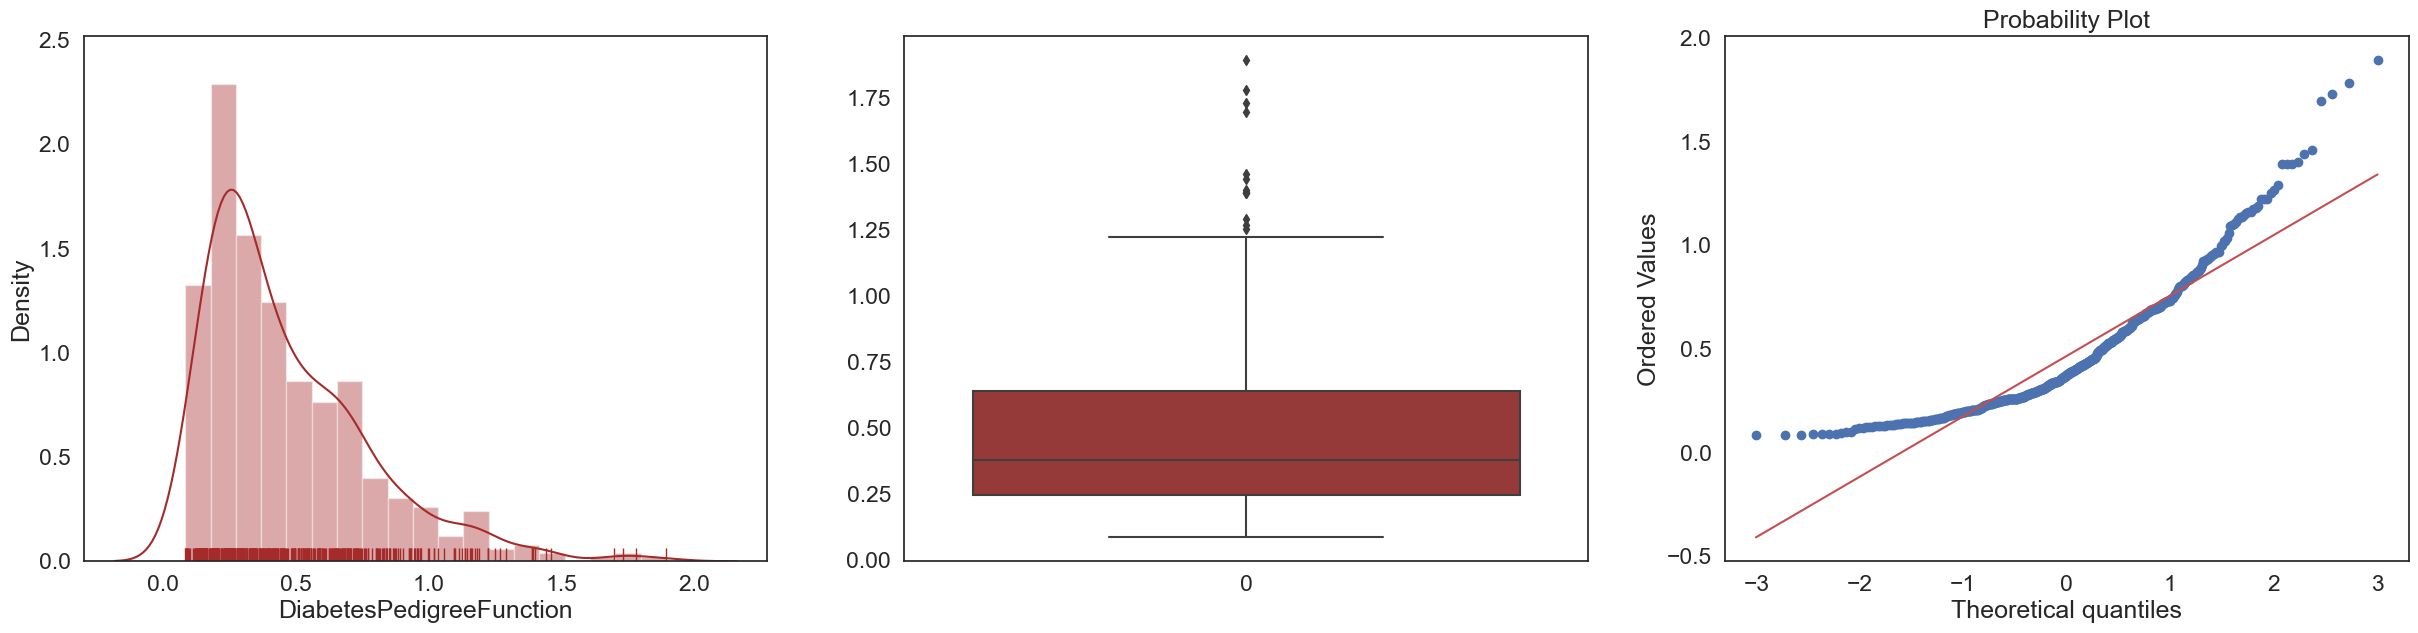

In [42]:
#概率密度曲线、箱线图与P-P图；
fig, axes = plt.subplots(1,3)
for i in range(1):
    sns.distplot(X_train[num_cols[6]],ax = plt.subplot(2,3,1)  ,rug=True,color='brown')
    sns.boxplot(X_train[num_cols[6]],ax = plt.subplot(2,3,2)  ,color='brown')  
    stats.probplot(X_train[num_cols[6]],plot = plt.subplot(2,3,3)) 

In [43]:
X_train = ppc1.out_remove('DiabetesPedigreeFunction',X_train)
X_test = ppc1.out_remove('DiabetesPedigreeFunction',X_test)

### Age

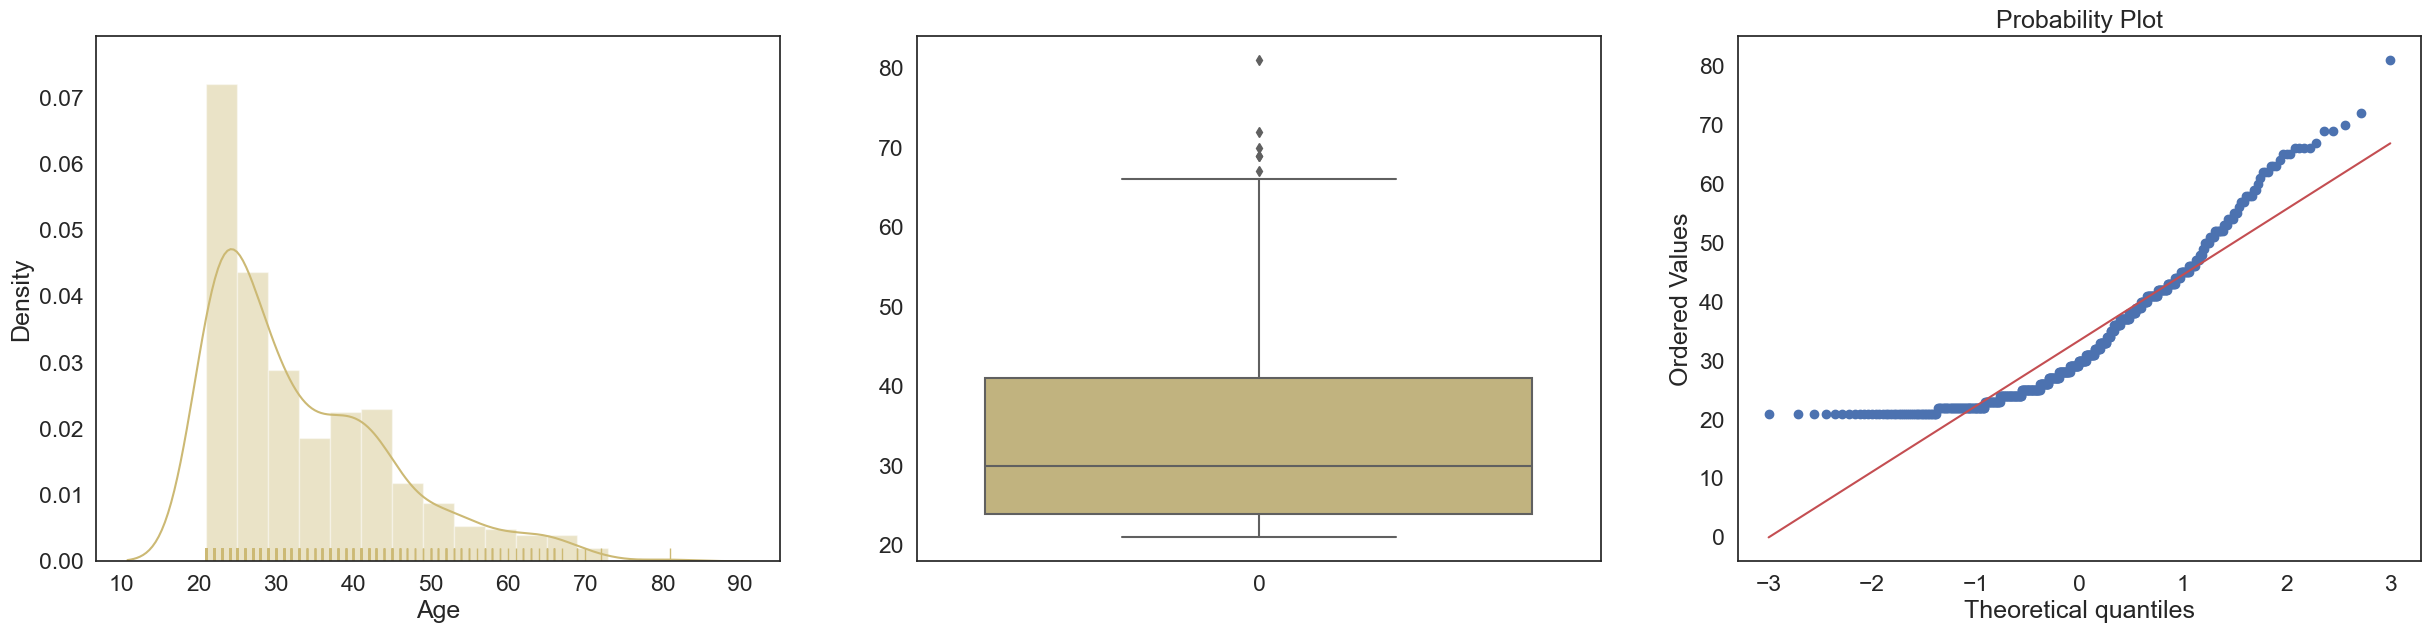

In [44]:
#概率密度曲线、箱线图与P-P图；
fig, axes = plt.subplots(1,3)
for i in range(1):
    sns.distplot(X_train[num_cols[7]],ax = plt.subplot(2,3,1)  ,rug=True,color='y')
    sns.boxplot(X_train[num_cols[7]],ax = plt.subplot(2,3,2)  ,color='y')  
    stats.probplot(X_train[num_cols[7]],plot = plt.subplot(2,3,3)) 

这里有一些异常值但是均为正常值，比如60，70，80岁都是合理值。

## 数据清洗后数据集

<Figure size 3000x1500 with 0 Axes>

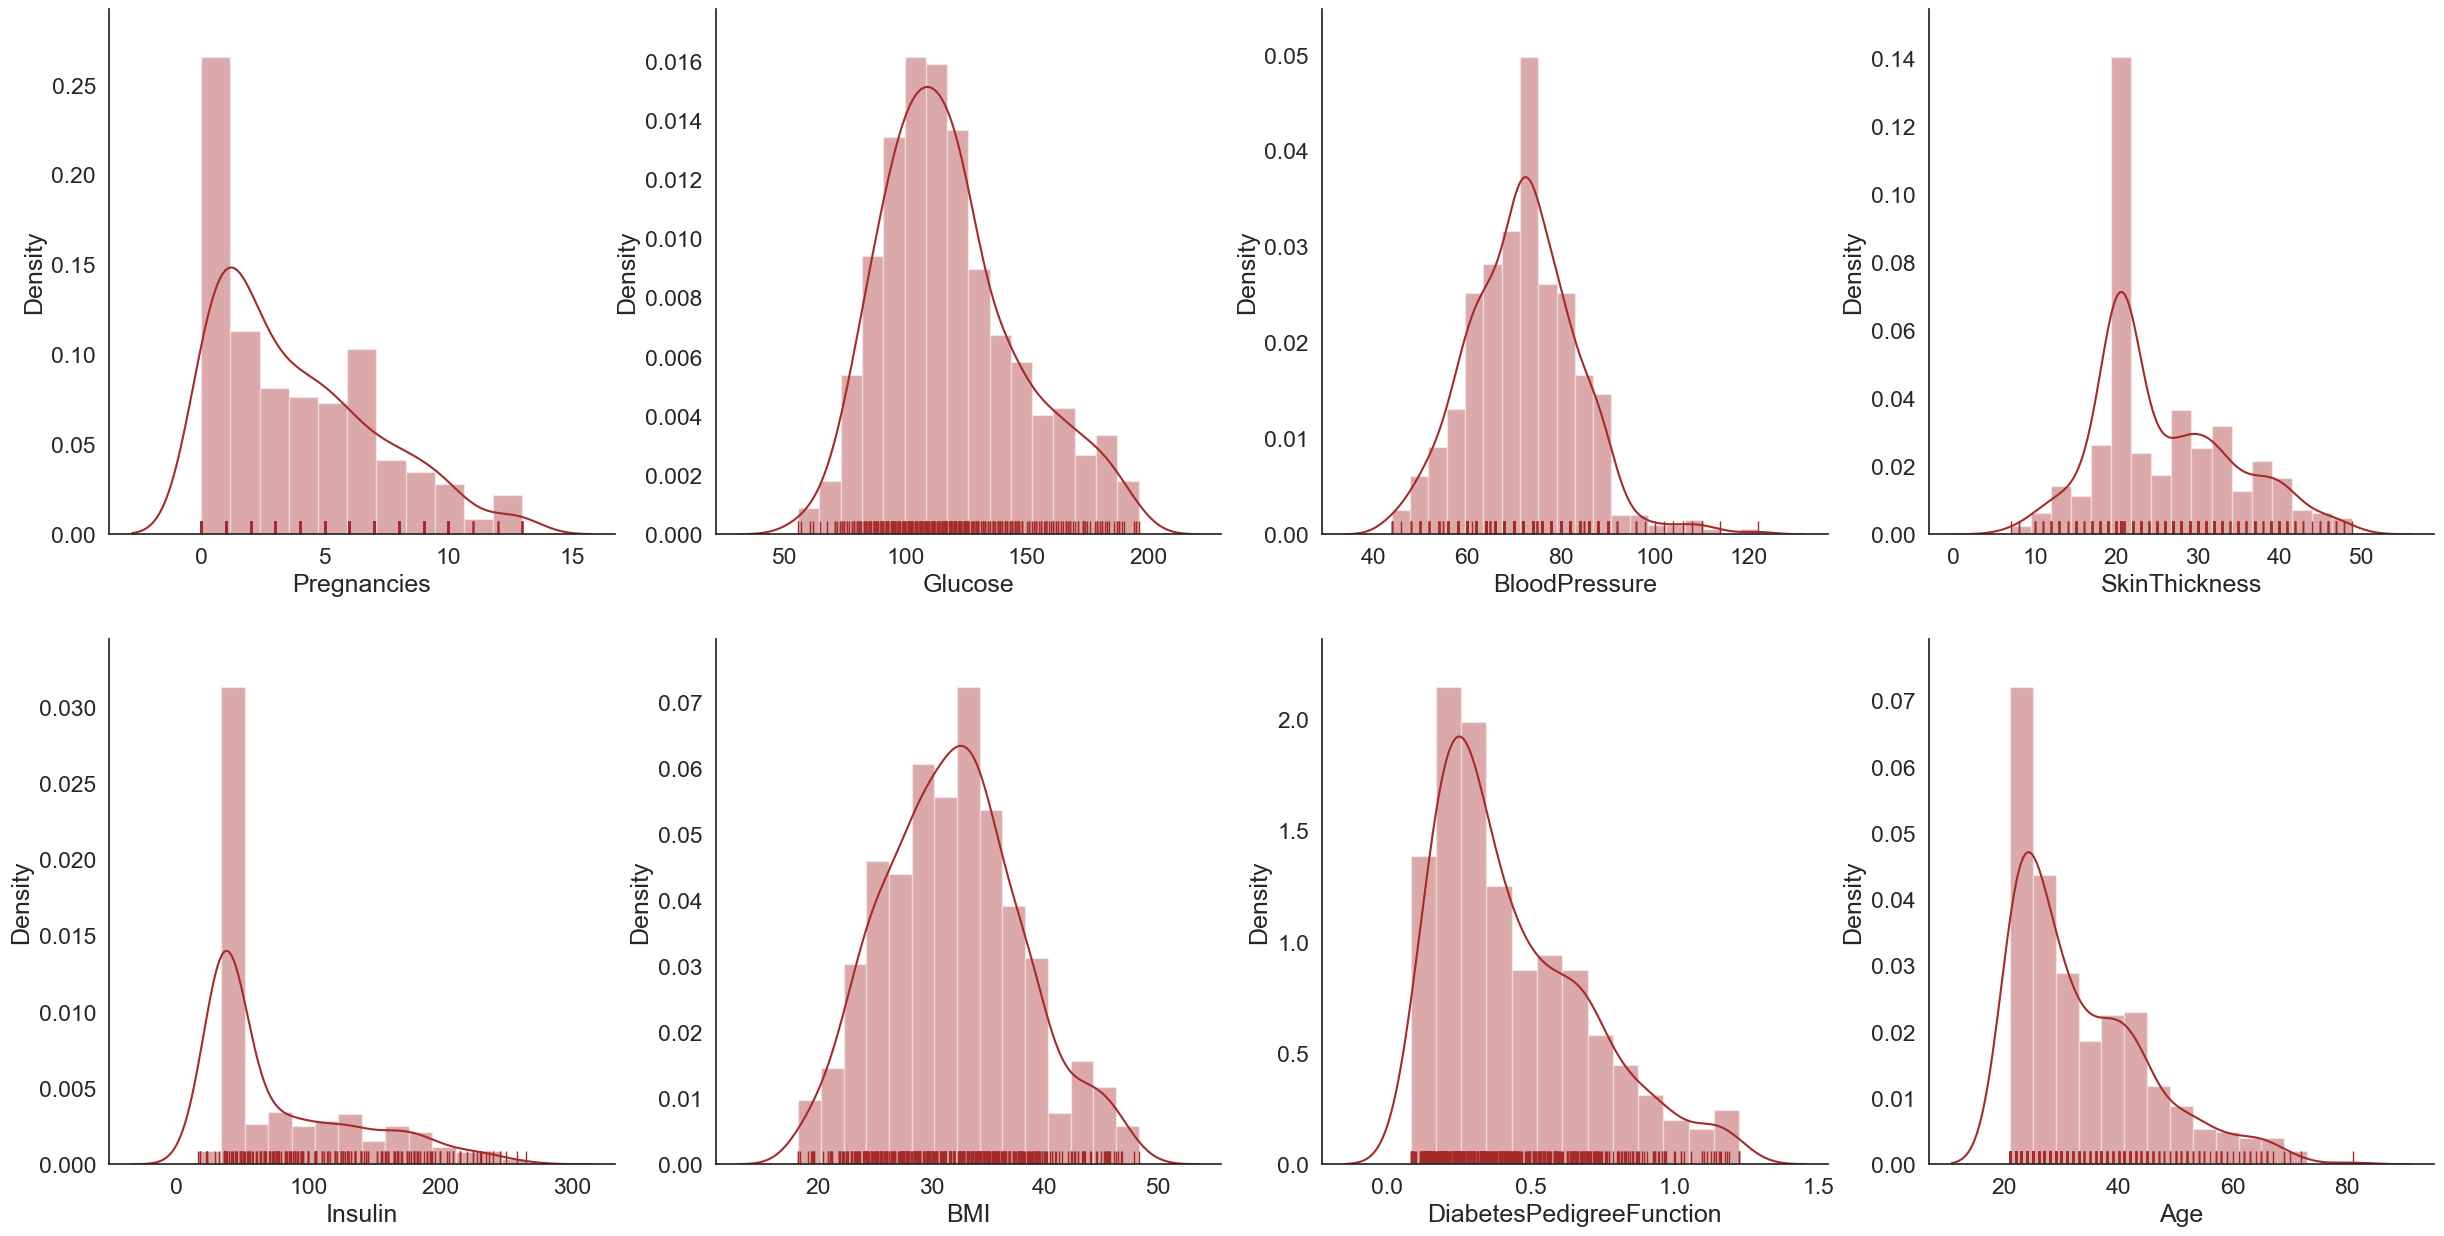

In [45]:
rcParams['figure.figsize'] =30,15
sns.set(font_scale = 1.5)
sns.set_style("white")
plt.subplots_adjust(hspace=1)
fig, axes = plt.subplots(2, 4)
for i in range(4):
    sns.distplot(X_train[num_cols[i]],ax = axes[0,i],rug=True,color='brown')
    sns.despine()
for i in range(4,8):
    sns.distplot(X_train[num_cols[i]],ax = axes[1,i-4],rug=True,color='brown')
    sns.despine()

## 相关矩阵

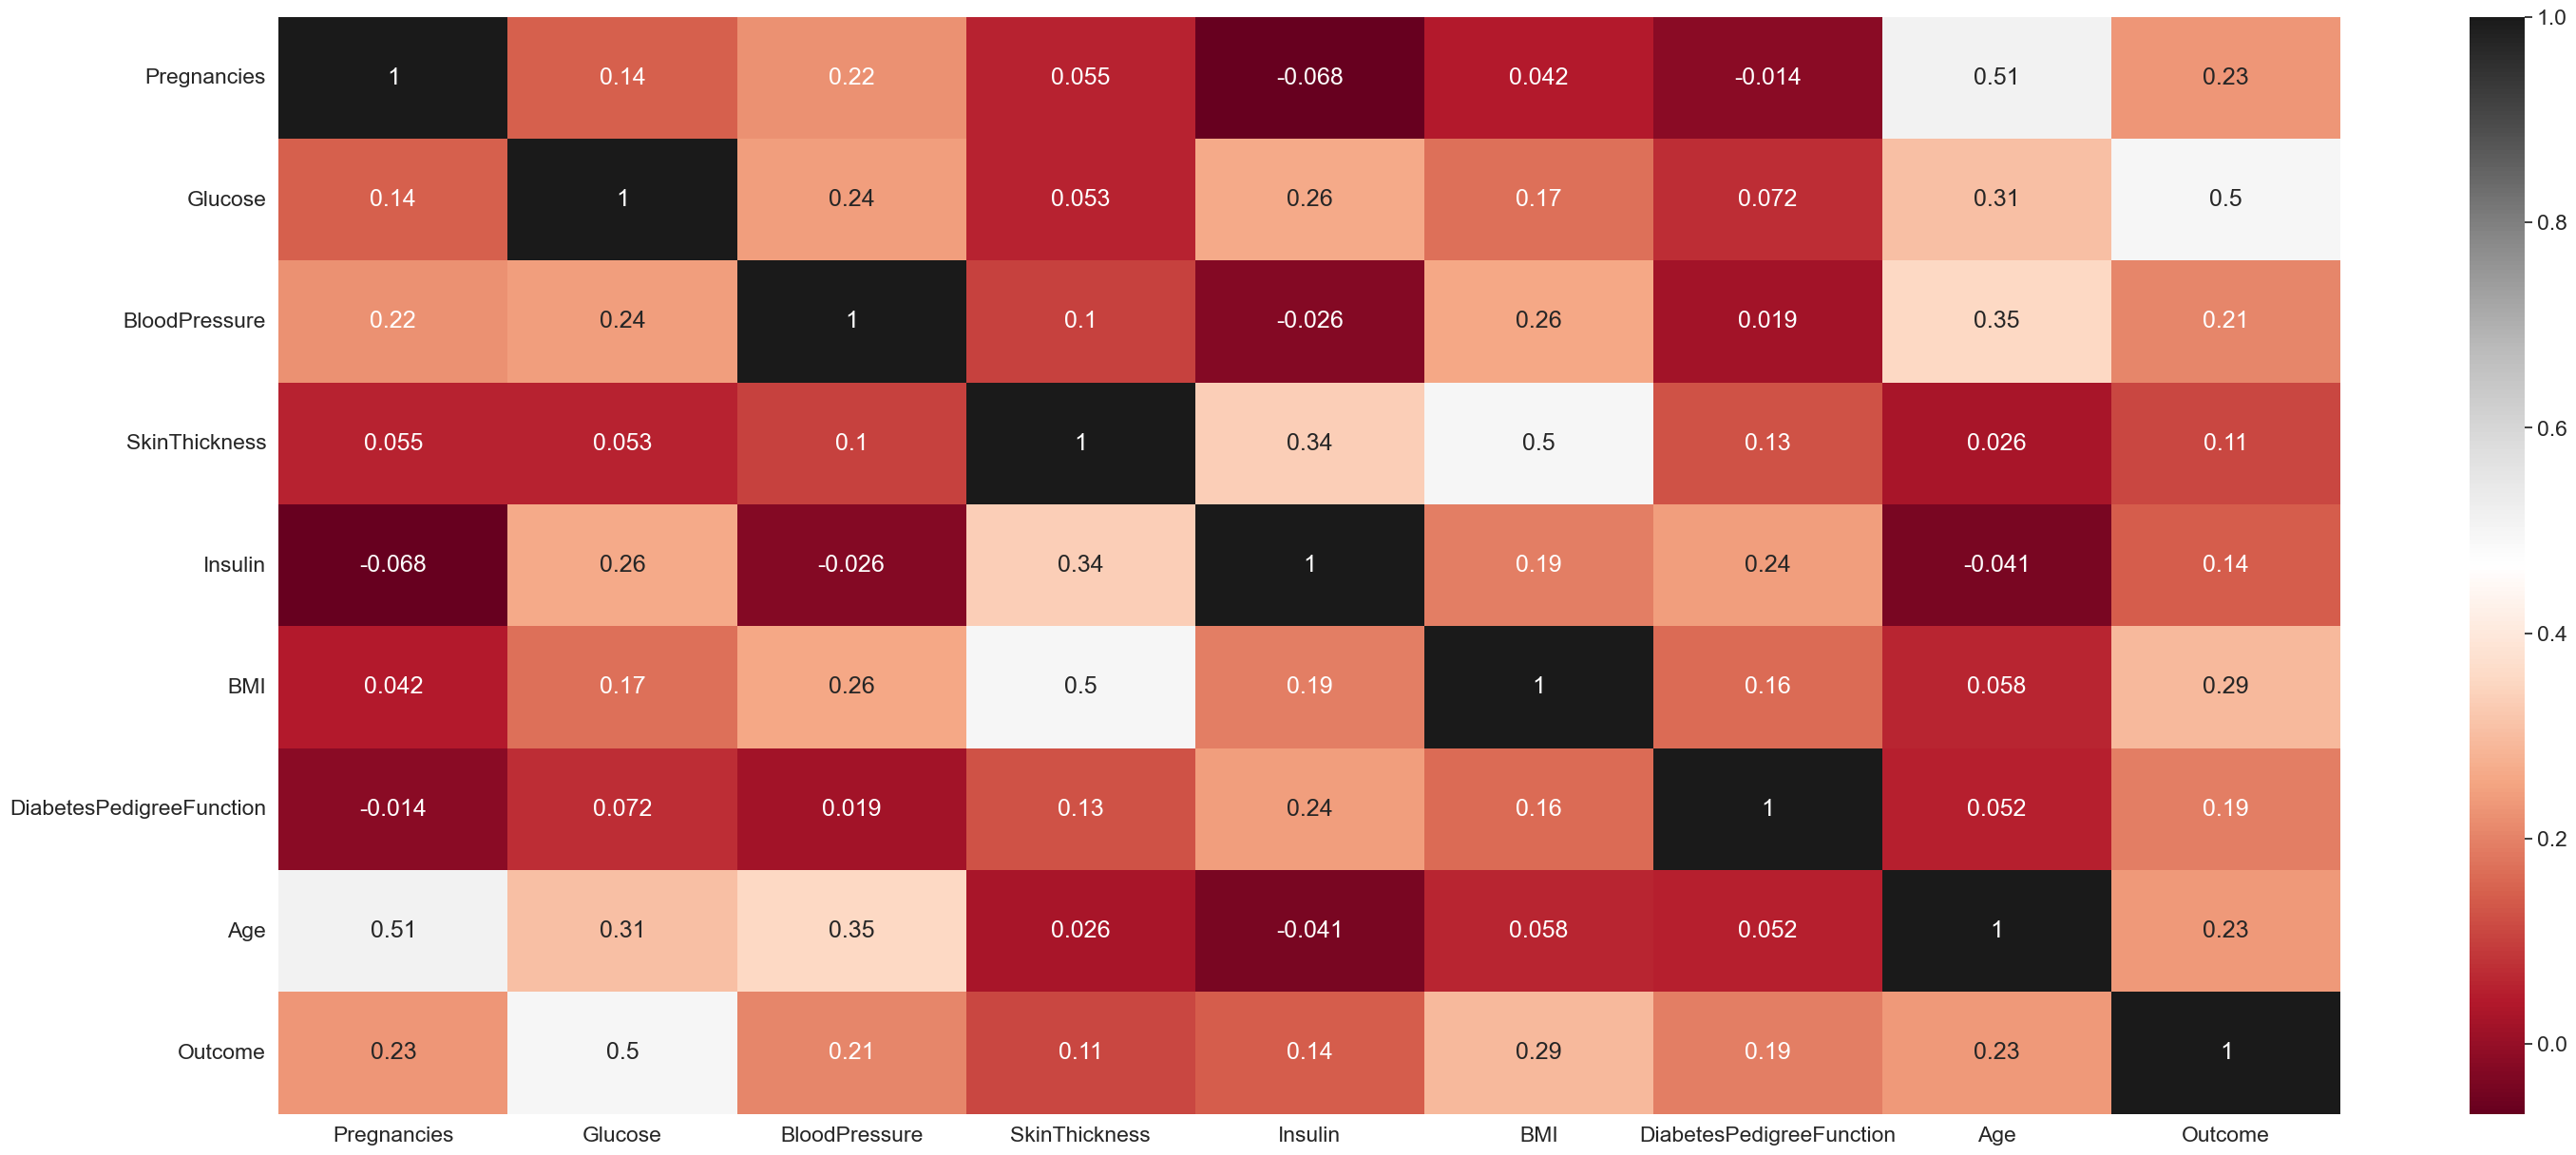

In [46]:
plt.figure(figsize = (35,15))
sns.heatmap(X_train.corr(),cmap = 'RdGy',annot = True,cbar=True);

Outcome和Glucose之间的相关性很高，Pregnancies和Age的相关性很高，SkinThickness和BMI高度相关。

## 特征重要度

<AxesSubplot: xlabel='Importance', ylabel='Feature'>

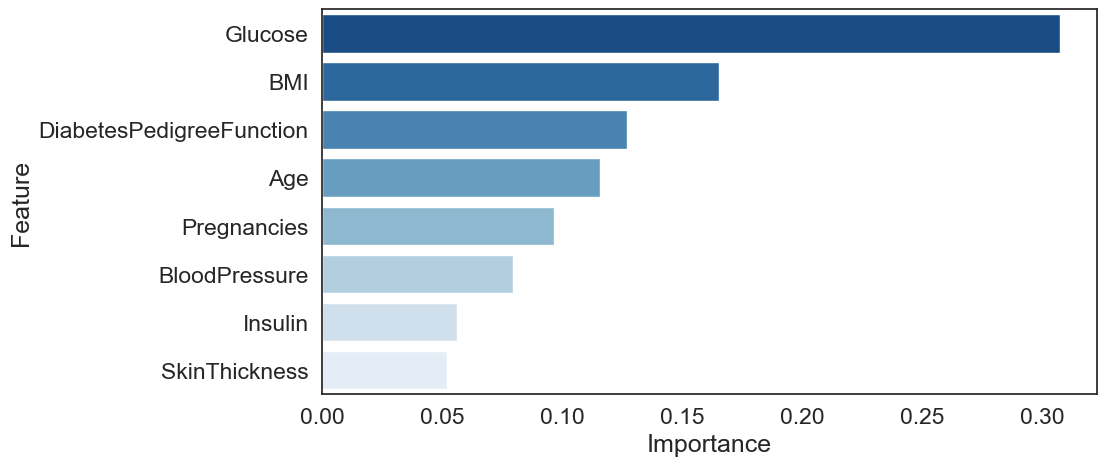

In [47]:
from sklearn.tree import DecisionTreeClassifier

#训练决策树模型；
plt.figure(figsize=(10, 5))

model = DecisionTreeClassifier()
z_copy = X_train.copy()
y = z_copy.iloc[:,-1]
X = z_copy.iloc[:,:-1]
model.fit(X, y)
importances = model.feature_importances_

indices = np.argsort(importances)[::-1]
df = pd.DataFrame({'Feature': X.columns[indices], 'Importance': importances[indices]})
sns.barplot(x='Importance', y='Feature', palette="Blues_r",data=df )

In [48]:
X_train.drop(['Insulin', 'SkinThickness'], axis=1, inplace=True)
X_test.drop(['Insulin', 'SkinThickness'], axis=1, inplace=True)

## 建模

In [49]:
y_train = X_train.iloc[:,-1]
X_train = X_train.iloc[:,:-1]
y_test = X_test.iloc[:,-1]
X_test = X_test.iloc[:,:-1]

In [50]:
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier 
from imblearn.over_sampling import SMOTE

In [51]:
#实现数据过采样，处理不平衡问题
SMT=SMOTE()

#实现数据归一化，处理量纲和单位的影响
scaler= StandardScaler()

#实现缩放，通过非线性转换将各个特征映射到高斯分布
QUAT = QuantileTransformer(random_state=5, output_distribution='normal')

### AdaBoost

In [52]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
Param = {
    'ada__n_estimators': [10, 25, 50, 75, 100, 125, 150, 175 , 200],
    'ada__learning_rate': [0.1, 0.5, 1.0],
}
p = Pipeline([('SMT', SMT),('scaler',scaler),('ada', ada)])
Grid=GridSearchCV(p,param_grid=Param,cv=5,scoring='recall')
Grid.fit(X_train,y_train)
print(Grid.best_score_)
print(Grid.best_params_)

0.762689393939394
{'ada__learning_rate': 0.5, 'ada__n_estimators': 25}


In [53]:
Final = AdaBoostClassifier(learning_rate= 0.5, n_estimators= 25)

Model = Pipeline([('SMT', SMT),('scaler',scaler), ('Final', Final)])
Model.fit(X_train, y_train)
Pred = Model.predict(X_test)

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       113
           1       0.59      0.69      0.64        51

    accuracy                           0.76       164
   macro avg       0.72      0.74      0.73       164
weighted avg       0.77      0.76      0.76       164



Text(0, 0.5, 'True positive rate')

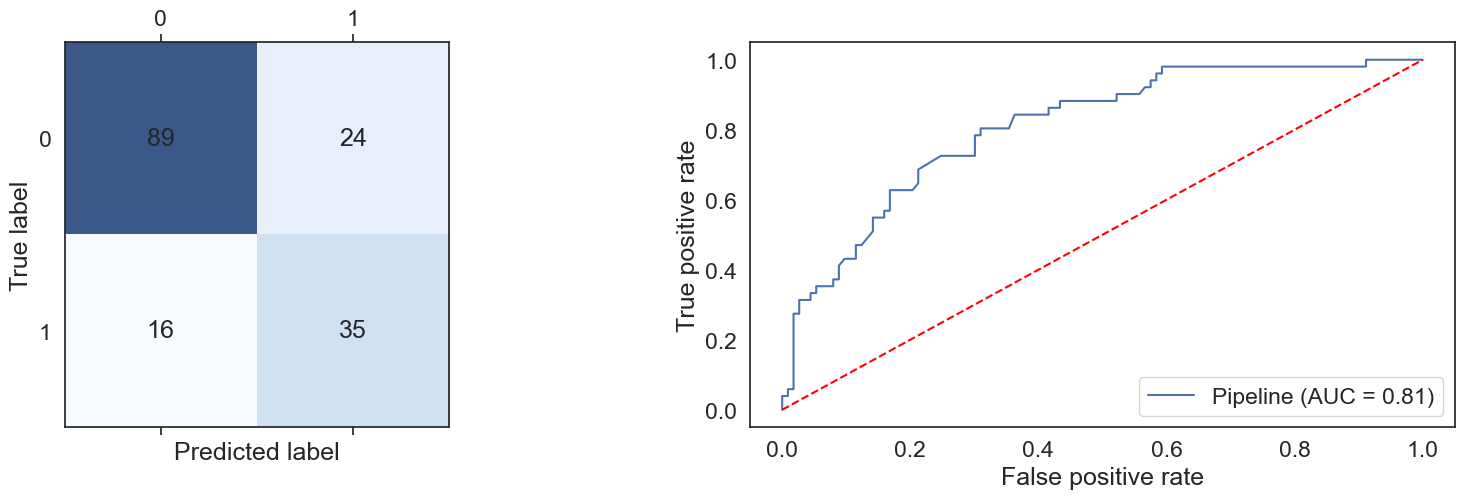

In [54]:
confusion = confusion_matrix(y_test, Pred)
print(classification_report(y_test, Pred))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.matshow(confusion, cmap='Blues',alpha=0.8)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        ax1.text(x=j, y=i, s=confusion[i, j], va='center', ha='center')
ax1.set_xlabel('Predicted label')
ax1.set_ylabel('True label')

plot_roc_curve(Model, X_test, y_test, ax=ax2)
ax2.plot([0, 1], [0, 1], linestyle='--', color='red')
ax2.set_xlabel('False positive rate')
ax2.set_ylabel('True positive rate')

### RandomForest 

In [55]:
from sklearn.ensemble import RandomForestClassifier

RANDOM_FOREST=RandomForestClassifier()
Param = {'RANDOM_FOREST__bootstrap': [True, False],
  'RANDOM_FOREST__max_depth': [10, 20, 30, None],
  'RANDOM_FOREST__n_estimators': [200, 600, 800]}
p = Pipeline([('SMT', SMT),('scaler',scaler),('RANDOM_FOREST', RANDOM_FOREST)])
Grid=GridSearchCV(p,param_grid=Param,cv=5,scoring='recall')
Grid.fit(X_train,y_train)
print(Grid.best_score_)
print(Grid.best_params_)

0.7017045454545454
{'RANDOM_FOREST__bootstrap': True, 'RANDOM_FOREST__max_depth': 10, 'RANDOM_FOREST__n_estimators': 600}


In [56]:
Final = RandomForestClassifier(bootstrap=True,n_estimators=600,max_depth=10)

Model = Pipeline([('SMT', SMT),('scaler',scaler), ('Final', Final)])
Model.fit(X_train, y_train)
Pred = Model.predict(X_test)

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       113
           1       0.58      0.67      0.62        51

    accuracy                           0.74       164
   macro avg       0.71      0.72      0.71       164
weighted avg       0.76      0.74      0.75       164



Text(0, 0.5, 'True positive rate')

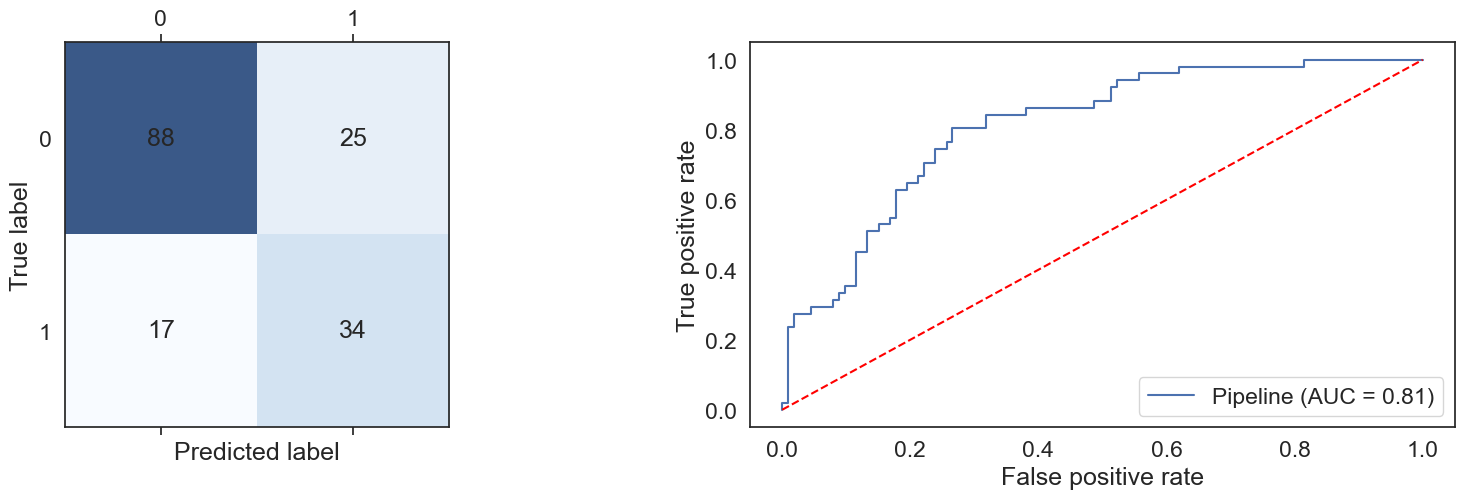

In [57]:
confusion = confusion_matrix(y_test, Pred)
print(classification_report(y_test, Pred))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.matshow(confusion, cmap='Blues',alpha=0.8)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        ax1.text(x=j, y=i, s=confusion[i, j], va='center', ha='center')
ax1.set_xlabel('Predicted label')
ax1.set_ylabel('True label')

plot_roc_curve(Model, X_test, y_test, ax=ax2)
ax2.plot([0, 1], [0, 1], linestyle='--', color='red')
ax2.set_xlabel('False positive rate')
ax2.set_ylabel('True positive rate')

### KNN

In [58]:
KNN=KNeighborsClassifier()
lis = list(range(1,300))
Param = {'KNN__n_neighbors': lis}
p = Pipeline([('SMT', SMT),('QUAT',QUAT),('KNN', KNN)])
Grid=GridSearchCV(p,param_grid=Param,cv=5,scoring='recall')
Grid.fit(X_train,y_train)
print(Grid.best_score_)
print(Grid.best_params_)

0.8842803030303031
{'KNN__n_neighbors': 183}


In [59]:
Final = KNeighborsClassifier(n_neighbors=183)

Model = Pipeline([('SMT', SMT),('QUAT',QUAT), ('Final', Final)])
Model.fit(X_train, y_train)
Pred = Model.predict(X_test)

              precision    recall  f1-score   support

           0       0.90      0.66      0.77       113
           1       0.53      0.84      0.65        51

    accuracy                           0.72       164
   macro avg       0.72      0.75      0.71       164
weighted avg       0.79      0.72      0.73       164



Text(0, 0.5, 'True positive rate')

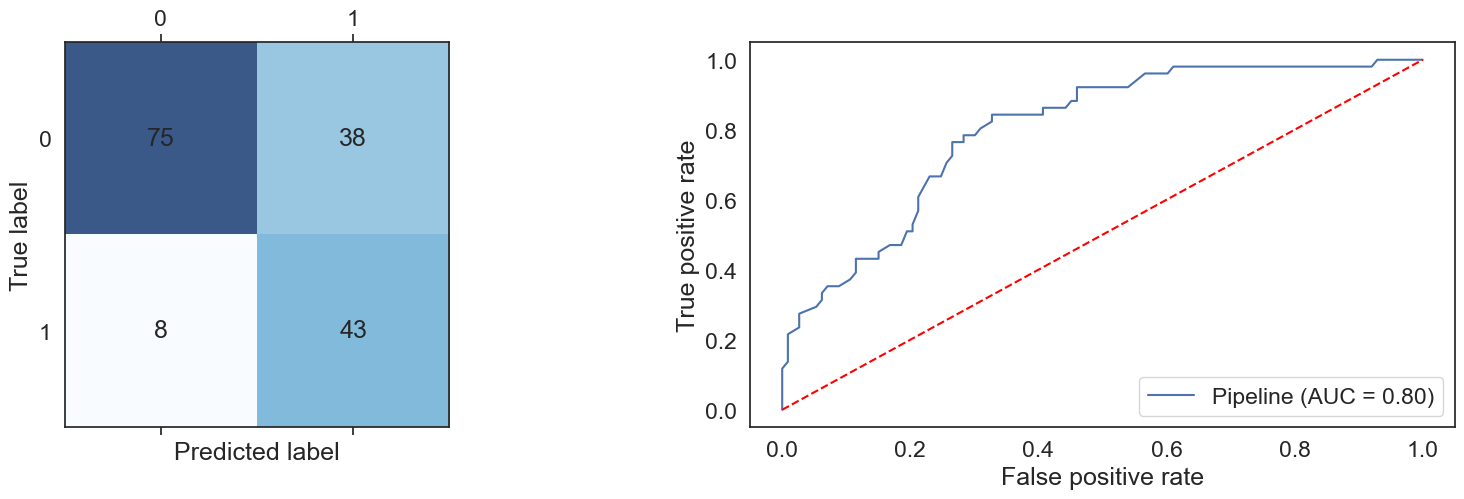

In [60]:
confusion = confusion_matrix(y_test, Pred)
print(classification_report(y_test, Pred))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.matshow(confusion, cmap='Blues',alpha=0.8)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        ax1.text(x=j, y=i, s=confusion[i, j], va='center', ha='center')
ax1.set_xlabel('Predicted label')
ax1.set_ylabel('True label')

plot_roc_curve(Model, X_test, y_test, ax=ax2)
ax2.plot([0, 1], [0, 1], linestyle='--', color='red')
ax2.set_xlabel('False positive rate')
ax2.set_ylabel('True positive rate')

### Logistic Regression

In [61]:
from sklearn.linear_model import LogisticRegression
LGR = LogisticRegression()

Param={"LGR__C":np.logspace(-3,3,7), "LGR__penalty":["l1","l2"]}

p = Pipeline([('SMT', SMT),('QUAT',QUAT),('LGR', LGR)])
Grid=GridSearchCV(p,param_grid=Param,cv=5,scoring='recall')
Grid.fit(X_train,y_train)
print(Grid.best_score_)
print(Grid.best_params_)

0.7742424242424242
{'LGR__C': 0.001, 'LGR__penalty': 'l2'}


In [62]:
Final = LogisticRegression(penalty='l2',C=0.001)

Model = Pipeline([('SMT', SMT),('QUAT',QUAT), ('Final', Final)])
Model.fit(X_train, y_train)
Pred = Model.predict(X_test)

              precision    recall  f1-score   support

           0       0.86      0.73      0.79       113
           1       0.56      0.75      0.64        51

    accuracy                           0.74       164
   macro avg       0.71      0.74      0.72       164
weighted avg       0.77      0.74      0.75       164



Text(0, 0.5, 'True positive rate')

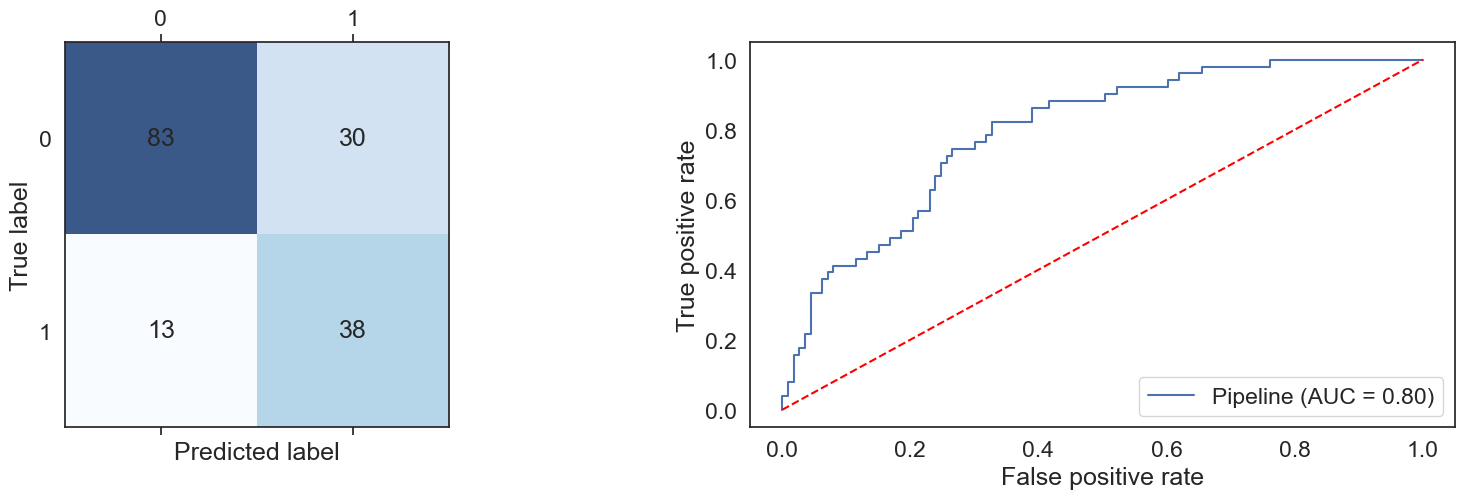

In [63]:
confusion = confusion_matrix(y_test, Pred)
print(classification_report(y_test, Pred))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.matshow(confusion, cmap='Blues',alpha=0.8)
for i in range(confusion.shape[0]):
    for j in range(confusion.shape[1]):
        ax1.text(x=j, y=i, s=confusion[i, j], va='center', ha='center')
ax1.set_xlabel('Predicted label')
ax1.set_ylabel('True label')

plot_roc_curve(Model, X_test, y_test, ax=ax2)
ax2.plot([0, 1], [0, 1], linestyle='--', color='red')
ax2.set_xlabel('False positive rate')
ax2.set_ylabel('True positive rate')

## 模型比较

<AxesSubplot: xlabel='Model', ylabel='Recall'>

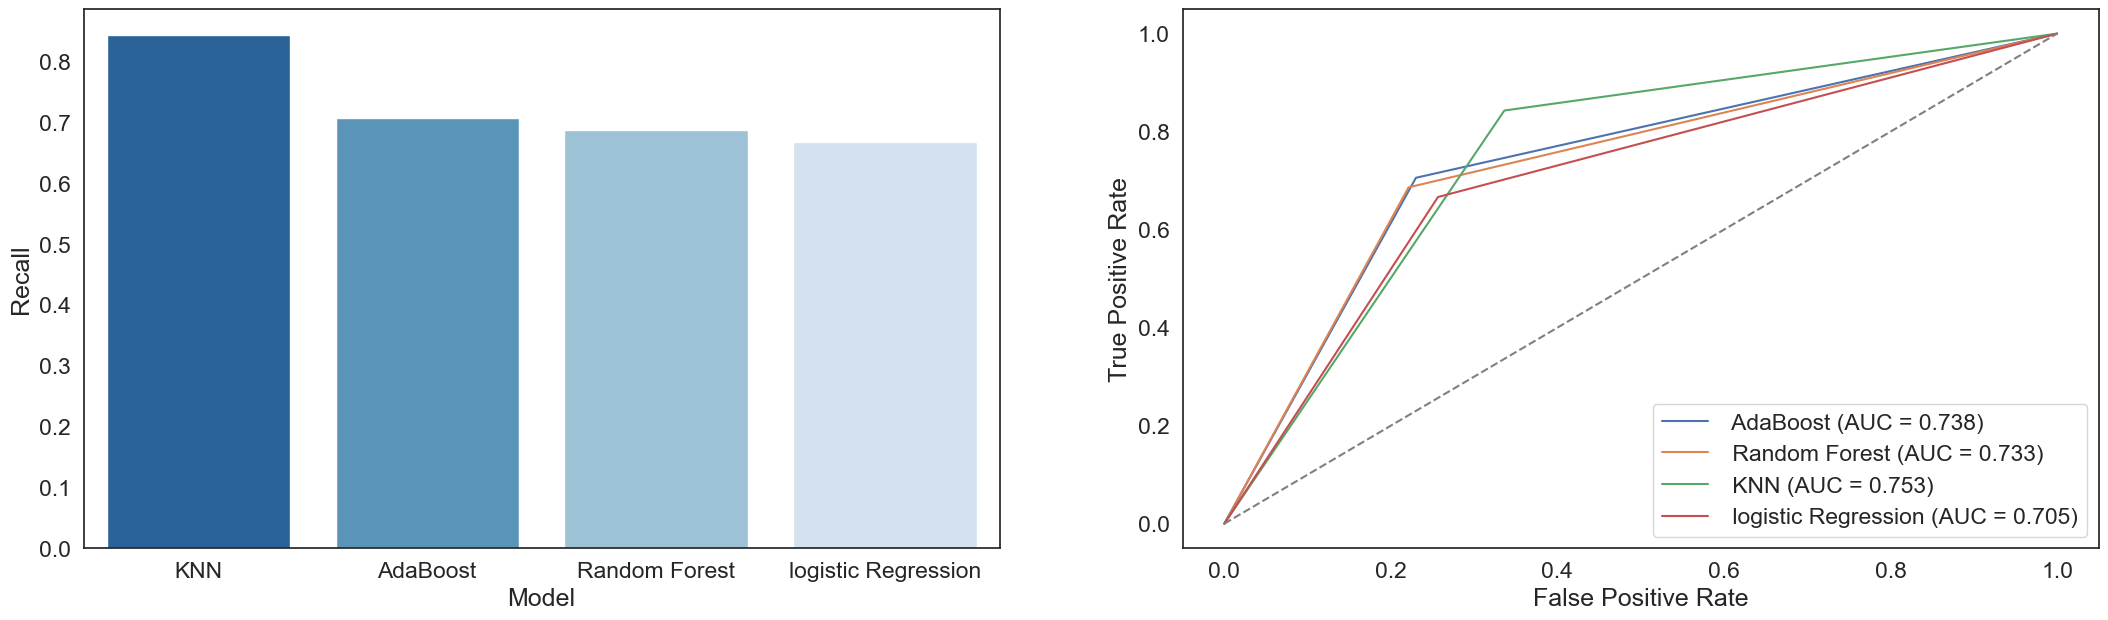

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 7),dpi=100)
# logistic Regression
Final = LogisticRegression(penalty='l2',C=0.01)
LGR = Pipeline([('SMT', SMT),('scaler',scaler), ('Final', Final)])
LGR.fit(X_train, y_train)
# KNN
Final = KNeighborsClassifier(n_neighbors=183)
KNN = Pipeline([('SMT', SMT),('QUAT',QUAT), ('Final', Final)])
KNN.fit(X_train, y_train)
# Random Forest
Final = RandomForestClassifier(bootstrap=True,n_estimators=600,max_depth=10)
rf = Pipeline([('SMT', SMT),('scaler',scaler), ('Final', Final)])
rf.fit(X_train, y_train)
# AdaBoost
Final = AdaBoostClassifier(learning_rate= 0.5, n_estimators= 25)
ada = Pipeline([('SMT', SMT),('scaler',scaler), ('Final', Final)])
ada.fit(X_train, y_train)

y_pred = np.array([ada.predict(X_test), rf.predict(X_test),KNN.predict(X_test),LGR.predict(X_test)])
model=['AdaBoost','Random Forest','KNN','logistic Regression']
recalls=[]
r=[]
Acurve=[]
for i in range(4):
    # Calculate FPR and TPR for this model
    fpr, tpr, _ = roc_curve(y_test, y_pred[i])
    roc_auc = auc(fpr, tpr)
    recalls.append([model[i],recall_score(y_test, y_pred[i])])
    r.append(recall_score(y_test, y_pred[i]))
    Acurve.append(roc_auc_score(y_test, y_pred[i]))
    plt.plot(fpr, tpr, label=' {} (AUC = {:.3f})'.format(model[i], roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
   
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

df = pd.DataFrame(recalls, columns=['Model', 'Recall'])
df = df.sort_values(by='Recall', ascending=False)
sns.barplot(x='Model', y='Recall', data=df, palette='Blues_r',ax=ax1)

In [65]:
plt.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10, 5)
df = pd.DataFrame({'AUC': Acurve, 'Recall': r}, index=model)
df.style.background_gradient()

,AUC,Recall
AdaBoost,0.737897,0.705882
Random Forest,0.732518,0.686275
KNN,0.753427,0.843137
logistic Regression,0.705015,0.666667
